TorchSDE
https://github.com/google-research/torchsde

Hiraiwa Model
https://link.aps.org/doi/10.1103/PhysRevLett.125.268104

In [1]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 29.6 MB/s eta 0:00:00
You should consider upgrading via the '/home/uwamichi/.pyenv/versions/3.8.13/bin/python3.8 -m pip install --upgrade pip' command.


dy(t) = f(t, y(t)) dt + g(t, y(t)) dW(t) 

y(t0) = y0 

In [295]:
import numpy as np
import torch
from torchsde import BrownianInterval, sdeint
import matplotlib.pyplot as plt
from matplotlib import patches
from ipywidgets import interact

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.device('cuda:0')))
print(torch.cuda.get_device_name(torch.device('cuda:1')))

2
TITAN V
GeForce GTX 1080


In [261]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

# nondimensionalize by setting 1
v0 = 1.0
r = 1.0

# fixed noise strength (0.1 in article)
D = 0.1

# external directional bias (0 or 0.1 in article)
A = 0.0

# boundary conditions (L=100 in article)
L = 20
periodic = True

# particle density (1 in article)
rho = 1

# strength of excluded volume force (fixed at 1)
beta = 1.0

# strength of contact following, contact inhibition of locomotion
A_CF = 0.1
A_CIL = -2.0

# numbers of cells, freedom, and noise source
batch_size, state_size, brownian_size = int(rho*(L**2)), 3, 1

# duration of simulation (6400 in the article)
t_max =  1000

# method to solve SDE
methodSDE = 'heun'
isIto = False

# time step to simulate
stepSDE = 1e-2


In [262]:
if periodic:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T   # neighbor - target
        dy = xy[:, 1:] - xy[:, 1:].T
        dx = dx % L
        dy = dy % L
        dx[dx > L/2] = dx[dx > L/2] - L
        dy[dy > L/2] = dy[dy > L/2] - L
        return [dx, dy]
else:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T
        dy = xy[:, 1:] - xy[:, 1:].T
        return [dx, dy]    

def J_CF(xy, dr, q):
    c = torch.unsqueeze(q[0], 1)   # cos, sin of neighbor
    s = torch.unsqueeze(q[1], 1)
    xy = (1 + xy[:,:,:1] * c + xy[:,:,1:] * s) * xy / 2
    return torch.nansum(xy, dim=0, keepdim=False)

def J_CIL(xy, d, r):
    xy = ((r/d) - 1) * xy
    return torch.nansum(xy, dim=0, keepdim=False)

In [263]:
class SDE(torch.nn.Module):
    noise_type = 'scalar'
    sde_type = 'ito' if isIto else 'stratonovich'

    def __init__(self, L, periodic, v0, beta, A_CF, A_CIL, r, A, D):
        super().__init__()
        self.L = L
        self.periodic = periodic
        self.v0 = v0
        self.beta = beta
        self.A_CF = A_CF
        self.A_CIL = A_CIL
        self.r = r
        self.A = A

        self.sigma = torch.zeros((batch_size, state_size, 1), device=device)
        self.sigma[:, 2, 0] = np.sqrt(2*D)
        
    # Drift
    def f(self, t, y):
#        print(y.shape)
        xy = y[:, :2]
#        if self.periodic:
#            xy = xy % L
        xy = xy2distance(xy, self.L)
#        print(np.shape(xy))
#        print(xy[0].shape)
        xy = torch.cat((torch.unsqueeze(xy[0], 2), torch.unsqueeze(xy[1], 2)), 2)
        d = torch.norm(xy, p='fro', dim=2, keepdim=True)
        dr = torch.heaviside(self.r - d, torch.tensor([0.0], device=device))
        xy = dr * torch.nn.functional.normalize(xy, p=2.0, dim=2)
        c = torch.cos(y[:, 2:])
        s = torch.sin(y[:, 2:])

        jcil = J_CIL(xy, d, self.r)
        
        dx0 = self.v0 * torch.cat((c, s), 1)
        dx1 = -self.beta * jcil
        dtheta0 = self.A_CF * J_CF(xy, dr, [c,s]) - self.A_CIL * jcil
        dtheta0 = c * dtheta0[:, 1:] - s * dtheta0[:, :1]
        dtheta1 = self.A * c
        return torch.cat((dx0+dx1, dtheta0+dtheta1), 1)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma


In [264]:
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)


y0 = torch.rand((batch_size, state_size), device=device)
y0 = torch.cat((y0[:,:2] * L, y0[:,2:] * (2*np.pi)), 1)

ts = torch.linspace(0, t_max, t_max+1, device=device)


# 

#y0 = torch.tensor([[5.0, 5.0, np.pi*0.4], [5.0, 5.5, np.pi*0.5]], device=device)
#y0 = torch.cat((y0[:,:2] * L, y0[:,2:] * (2*np.pi)), 1)

#ts = torch.linspace(0, 60, 3001, device=device)

#

bm = BrownianInterval(t0=ts[0], 
                      t1=ts[-1], 
                      size=(batch_size, brownian_size),
                      dt=stepSDE,
                      device=device)

In [265]:
print(ts)

tensor([   0.,    1.,    2.,  ...,  998.,  999., 1000.], device='cuda:1')


In [266]:
def testfun(x):
    x = torch.zeros((2,3), device=device)
    return x

x = torch.ones((2,3), device = device)
print(x)
testfun(x)
print(x)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:1')
tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:1')


In [267]:
sde = SDE(L, periodic, v0, beta, A_CF, A_CIL, r, A, D)

ys = sdeint(sde, y0, ts, bm=bm, dt=stepSDE, method=methodSDE)

In [299]:
circ_plot = MarkerStyle('o')
circ_bbox = circ_plot.get_path().transformed(circ_plot.get_transform()).get_extents()
circ_width = circ_bbox.width
circ_height = circ_bbox.height
print(circ_bbox)
print(circ_width)

Bbox(x0=-0.5, y0=-0.5, x1=0.5, y1=0.5)
1.0


In [310]:
cm = plt.cm.hsv


@interact(t_plot=(0, t_max-1))
def f(t_plot):

  x = ys[t_plot,:,0].cpu().detach().numpy() % L
  y = ys[t_plot,:,1].cpu().detach().numpy() % L
  theta = ys[t_plot,:,2].cpu().detach().numpy() % (2*np.pi)

  fig, ax = plt.subplots()
  plt.title("polarity t = " + str(ts[t_plot].cpu().detach().numpy()))
  ax.set_aspect('equal')
  im = ax.quiver(x, y, np.cos(theta)*r, np.sin(theta)*r, theta, cmap=cm, scale = 1,scale_units='xy', pivot='mid')
  plt.xlim(0, L)
  plt.ylim(0, L)
  fig.colorbar(im)
  im.set_clim(0, 2*np.pi)
  '''Mfig = ax.transData.get_matrix()
  xscale_Mfig = Mfig[0,0]
  yscale_Mfig = Mfig[1,1]
  print((xscale_Mfig * r / circ_width)**2)
  ax.scatter(x, y, s = (xscale_Mfig * r / circ_width)**2, color='k', facecolor='none', marker = 'o')'''



interactive(children=(IntSlider(value=499, description='t_plot', max=999), Output()), _dom_classes=('widget-in…

In [285]:
print(ys.shape)

NameError: name 'Mfig' is not defined

In [270]:
import datetime
import os
import codecs

now = datetime.datetime.now()
savedir = './HiraiwaModel_' + now.strftime('%Y%m%d_%H%M%S')
os.makedirs(savedir, exist_ok=True)

np.savez(os.path.join(savedir, 'params.npz'),
         v0 = v0, r = r, D = D, A = A, L = L,
         rho = rho, beta = beta, A_CF = A_CF, A_CIL = A_CIL, 
         batch_size = batch_size, state_size = state_size, brownian_size = brownian_size,
         periodic = periodic, t_max = t_max, methodSDE = methodSDE, isIto = isIto, stepSDE = stepSDE)

loaddir = savedir
params = np.load(loaddir+'/params.npz', allow_pickle=True)

txtstring = []
for k in params.files:
    txtstring.append("{} = {}".format(k, params[k]))

print(*txtstring, sep="\n", file=codecs.open(loaddir+'/params.txt', 'w', 'utf-8'))

In [271]:
plt.rcParams['figure.figsize'] = [12, 9]

cm = plt.cm.hsv

for t_plot in range(len(ts)):

  x = ys[t_plot,:,0].cpu().detach().numpy() % L
  y = ys[t_plot,:,1].cpu().detach().numpy() % L
  theta = ys[t_plot,:,2].cpu().detach().numpy() % (2*np.pi)

  fig, ax = plt.subplots()
  plt.title("polarity t = " + str(ts[t_plot].cpu().detach().numpy()))
  ax.set_aspect('equal')
  im = ax.quiver(x, y, np.cos(theta)*r, np.sin(theta)*r, theta, cmap=cm, scale = 1,scale_units='xy', pivot='mid')
  plt.xlim(0, L)
  plt.ylim(0, L)
  fig.colorbar(im)
  im.set_clim(0, 2*np.pi)
  
  fig.savefig(os.path.join(savedir, format(t_plot, '03d'))+'.png', format='png')
    
  plt.clf()
  plt.close()


In [272]:
theta = ys[:,:,2].cpu().detach().numpy()
print(theta)

[[ 6.24110270e+00  4.56161642e+00  5.68621588e+00 ...  6.10488176e+00
   9.63855863e-01  3.38003135e+00]
 [ 6.32778072e+00  4.41603374e+00  5.17166853e+00 ...  6.30771732e+00
   1.14620719e-02  4.69882679e+00]
 [ 6.74028444e+00  5.61429548e+00  4.50202799e+00 ...  6.00616503e+00
   4.48887050e-01  4.32074928e+00]
 ...
 [ 4.84228516e+00 -1.56876354e+01 -1.88754616e+01 ...  1.75390625e+00
  -8.75213432e+00  1.52044115e+01]
 [ 4.81499386e+00 -1.56546249e+01 -1.92871552e+01 ...  1.64330196e+00
  -8.88664436e+00  1.49581165e+01]
 [ 5.10992622e+00 -1.52878876e+01 -1.88358326e+01 ...  1.50191116e+00
  -8.95573235e+00  1.46561642e+01]]


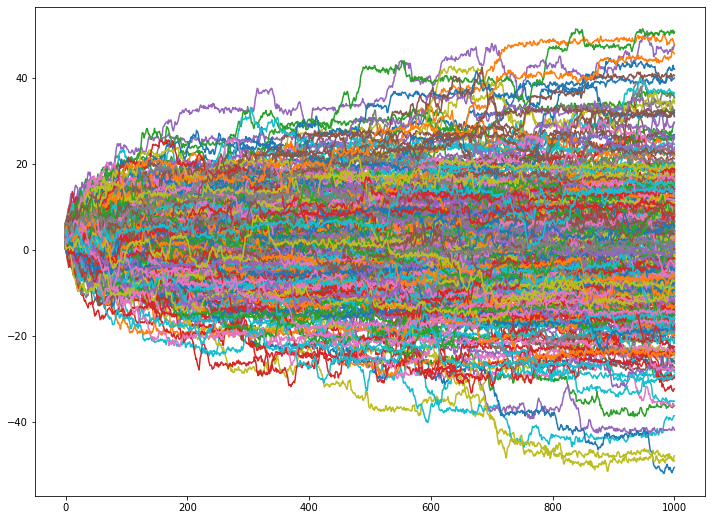

In [273]:
plt.plot(theta)

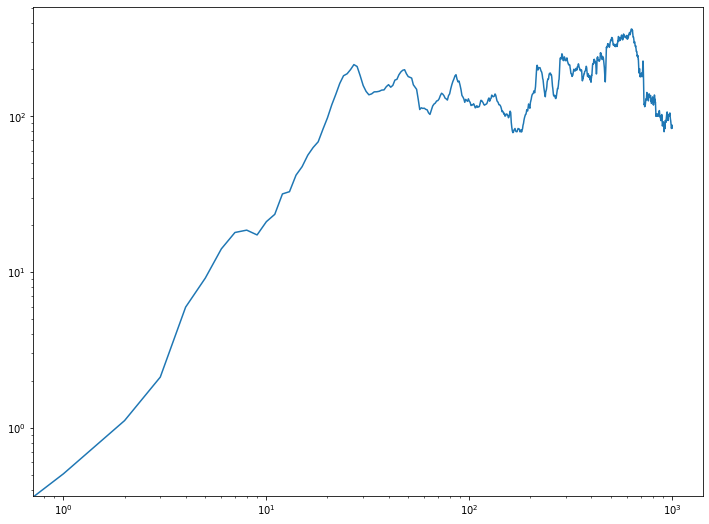

In [274]:
def MSD(ys):
    yy = ys - ys[0]
    msd0 = (yy**2).cpu().detach().numpy()
    return [np.sum(msd0[:, 0, :2], axis=1), msd0[:, 0, 2]]

msd1 = MSD(ys)[0]
plt.loglog(msd1)

In [275]:
spatialD = v0**2 / (2 * D)

In [276]:
plt.loglog(msd1[1:]/(4 * spatialD * np.arange(1,301)))

ValueError: operands could not be broadcast together with shapes (1000,) (300,) 